## Lab 3: Defeating Common Sense (Local Realism) with the CHSH Inequality##

### Two-Qubit Correlated Variables

In [1]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.12.0',
 'qiskit-aer': '0.4.1',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.5.0',
 'qiskit-aqua': '0.6.5',
 'qiskit': '0.16.2'}

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info.analysis import average_data

In [4]:
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
provider = IBMQ.load_account()

In [5]:
sim_backend = BasicAer.get_backend('qasm_simulator')
sim_shots = 8192

# use device to test entanglement
device_shots = 1024
device_backend = least_busy(provider.backends(operational=True, 
                                              simulator=False, 
                                              n_qubits=5))

print("the best backend is " + device_backend.name())

the best backend is ibmq_rome


In [6]:
# Creating registers
q = QuantumRegister(2)
c = ClassicalRegister(2)

# quantum circuit to make an entangled bell state 
bell = QuantumCircuit(q, c)
bell.h(q[0])
bell.cx(q[0], q[1])

# quantum circuit to measure q in the standard basis 
measureZZ = QuantumCircuit(q, c)
measureZZ.measure(q[0], c[0])
measureZZ.measure(q[1], c[1])
bellZZ = bell+measureZZ

# quantum circuit to measure q in the superposition basis 
measureXX = QuantumCircuit(q, c)
measureXX.h(q[0])
measureXX.h(q[1])
measureXX.measure(q[0], c[0])
measureXX.measure(q[1], c[1])
bellXX = bell+measureXX

# quantum circuit to measure ZX
measureZX = QuantumCircuit(q, c)
measureZX.h(q[0])
measureZX.measure(q[0], c[0])
measureZX.measure(q[1], c[1])
bellZX = bell+measureZX

# quantum circuit to measure XZ
measureXZ = QuantumCircuit(q, c)
measureXZ.h(q[1])
measureXZ.measure(q[0], c[0])
measureXZ.measure(q[1], c[1])
bellXZ = bell+measureXZ

circuits = [bellZZ,bellXX,bellZX,bellXZ]

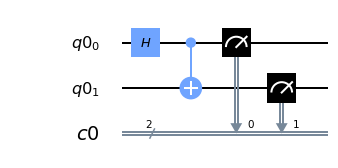

In [7]:
bellZZ.draw(output='mpl')

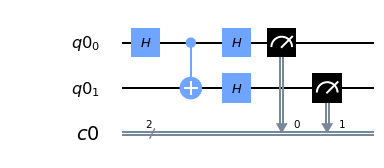

In [8]:
bellXX.draw(output='mpl')

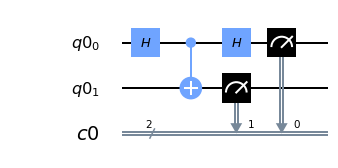

In [9]:
bellZX.draw(output='mpl')

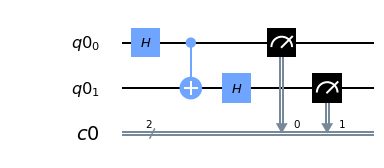

In [10]:
bellXZ.draw(output='mpl')

In [11]:
job = execute(circuits, 
              backend=device_backend, 
              shots=device_shots, 
              optimization_level=3)
job_monitor(job)

Job Status: job has successfully run


In [12]:
result = job.result()

In [13]:
observable_first = {'00': 1, '01': -1, '10': 1, '11': -1}
observable_second = {'00': 1, '01': 1, '10': -1, '11': -1}
observable_correlated = {'00': 1, '01': -1, '10': -1, '11': 1}

In [14]:
print('IZ = ' + str(average_data(result.get_counts(bellZZ),observable_first)))
print('ZI = ' + str(average_data(result.get_counts(bellZZ),observable_second)))
print('ZZ = ' + str(average_data(result.get_counts(bellZZ),observable_correlated)))

print('IX = ' + str(average_data(result.get_counts(bellXX),observable_first)))
print('XI = ' + str(average_data(result.get_counts(bellXX),observable_second)))
print('XX = ' + str(average_data(result.get_counts(bellXX),observable_correlated)))

print('ZX = ' + str(average_data(result.get_counts(bellZX),observable_correlated)))
print('XZ = ' + str(average_data(result.get_counts(bellXZ),observable_correlated)))

IZ = 0.029296875
ZI = -0.0078125
ZZ = 0.814453125
IX = -0.001953125
XI = -0.04296875
XX = 0.806640625
ZX = -0.03125
XZ = 0.06640625


### What does it all mean? ###

An entangled state, $|\psi \rangle = \frac{|00> + |11>}{\sqrt{2}}$, can be made by a Hadamard gate on the controlled qubit and a CNOT gate with $q_0$ as the control and $q_1$ as the target. We see that the expected value of the observable ZZ and XX are approximately 1, with experimental errors. 

In this state $|\psi \rangle$, the expectation values are explainable with the concept of a hidden variable $\lambda$, with two bits each occuring randomly with probability $\frac{1}{4}$, where 

\begin{equation}
\langle A \otimes B \rangle = \sum_\lambda P(\lambda) A(\lambda) B(\lambda). 
\end{equation}

The assumptions are that no information can travel faster than the speed of light, and that all observables have a definite eigenvalue.

### CHSH Inequality

In [15]:
CHSH = lambda x : x[0]+x[1]+x[2]-x[3]
measure = [measureZZ, measureZX, measureXX, measureXZ]

In [ ]:
# Theory

In [16]:
sim_chsh_circuits = []
sim_x = []

sim_steps = 30
for step in range(sim_steps):
    theta = 2.0*np.pi*step/30
    bell_middle = QuantumCircuit(q,c)
    bell_middle.ry(theta,q[0])
    for m in measure:
        sim_chsh_circuits.append(bell+bell_middle+m)
    sim_x.append(theta)

In [17]:
job = execute(sim_chsh_circuits, 
              backend=sim_backend, 
              shots=sim_shots, 
              optimization_level=3)
result = job.result()

In [18]:
sim_chsh = []
circ = 0

for x in range(len(sim_x)):
    temp_chsh = []
    for m in range(len(measure)):
        temp_chsh.append(average_data(result.get_counts(sim_chsh_circuits[circ].name),observable_correlated))
        circ += 1
    sim_chsh.append(CHSH(temp_chsh))

In [ ]:
# Experiment

In [19]:
real_chsh_circuits = []
real_x = []

real_steps = 10
for step in range(real_steps):
    theta = 2.0*np.pi*step/10
    bell_middle = QuantumCircuit(q,c)
    bell_middle.ry(theta,q[0])
    for m in measure:
        real_chsh_circuits.append(bell+bell_middle+m)
    real_x.append(theta)

In [20]:
job = execute(real_chsh_circuits, 
              backend=device_backend, 
              shots=device_shots, 
              optimization_level=3)
job_monitor(job)

Job Status: job has successfully run


In [21]:
result = job.result()

In [22]:
real_chsh = []
circ = 0

for x in range(len(real_x)):
    temp_chsh = []
    for m in range(len(measure)):
        temp_chsh.append(average_data(result.get_counts(real_chsh_circuits[circ].name),observable_correlated))
        circ += 1
    real_chsh.append(CHSH(temp_chsh))

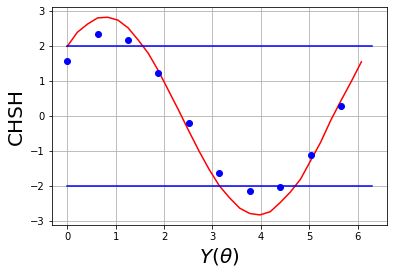

In [23]:
plt.plot(sim_x, sim_chsh, 'r-', real_x, real_chsh, 'bo')
plt.plot([0, 2*np.pi], [2, 2], 'b-')
plt.plot([0, 2*np.pi], [-2, -2], 'b-')
plt.grid()
plt.ylabel('CHSH', fontsize=20)
plt.xlabel(r'$Y(\theta)$', fontsize=20)
plt.show()

In [24]:
print(real_chsh)

[1.5546875, 2.326171875, 2.154296875, 1.224609375, -0.2109375, -1.62890625, -2.162109375, -2.033203125, -1.107421875, 0.287109375]


### What does it all mean? ###

The CHSH inequality says that no local hidden variable theory can have $|C| >2$, where 

\begin{equation}
C = \langle B \otimes A \rangle + \langle B \otimes A' \rangle + \langle B' \otimes A' \rangle - \langle B' \otimes A \rangle. 
\end{equation}

Here there are four observables: $A$ and $A'$ on $q_0$ and $B$ and $B'$ on $q_1$ with eigenvalues +/- 1. With a hidden variable model, 

\begin{equation}
C = \sum_\lambda P(\lambda) \left( [A(\lambda) + A'(\lambda)] B(\lambda) + [A'(\lambda) - A(\lambda)]B'(\lambda) \right)
\end{equation}

where both $[A(\lambda) + A'(\lambda)]$ and $[A'(\lambda) - A(\lambda)]$ are either 0 or 2. Thus, $|C|=2$. So if $C > 2$ the CHSH inequality is clearly violated, and supports the case of no local hidden variables in quantum entanglement. 

As in this case, if the observables Z (computational basis) and X (superposition basis) are chosen, 

\begin{equation}
C = \langle Z \otimes Z \rangle + \langle Z \otimes X \rangle + \langle X \otimes X \rangle - \langle X \otimes Z \rangle,
\end{equation}

and the state is in 

\begin{equation}
|\psi(\theta)\rangle = \frac{ cos \frac{\theta}{2} |00\rangle + cos \frac{\theta}{2} |11\rangle + sin \frac{\theta}{2} |01\rangle - sin \frac{\theta}{2} |10\rangle }{\sqrt{2}} .
\end{equation}

Using the above state, we derive a theoretical expression for $C(\theta)$,

\begin{aligned}
C & = \langle Z \otimes Z \rangle + \langle Z \otimes X \rangle + \langle X \otimes X \rangle - \langle X \otimes Z \rangle \\\\
& = \langle \psi | Z \otimes Z | \psi \rangle + \langle \psi | Z \otimes X | \psi \rangle + \langle \psi | X \otimes X | \psi \rangle - \langle \psi | X \otimes Z | \psi \rangle \\\\
& = \left( cos^2 \frac{\theta}{2} - sin^2 \frac{\theta}{2} \right) + \left( 2 cos \frac{\theta}{2} sin \frac{\theta}{2} \right) + \left( cos^2 \frac{\theta}{2} - sin^2 \frac{\theta}{2} \right) + \left( 2 cos \frac{\theta}{2} sin \frac{\theta}{2} \right) \\\\
& = 2 cos^2 \frac{\theta}{2} - 2 sin^2 \frac{\theta}{2} + 4 cos \frac{\theta}{2} sin \frac{\theta}{2} \\\\
& = 2 \left( cos^2 \frac{\theta}{2} - sin^2 \frac{\theta}{2} + 2 cos \frac{\theta}{2} sin \frac{\theta}{2} \right).
\end{aligned}

To check our derived expression of $C$ we can overlay the the plot on top of the theoretical curve plotted above:

In [78]:
from numpy import pi, cos, sin

theta_np = np.asarray(sim_x)

def f(x):
    return 2*(cos(x/2))**2 - 2*(sin(x/2))**2 + 4*cos(x/2)*sin(x/2)

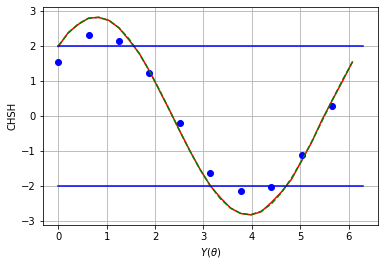

In [79]:
plt.plot(sim_x, sim_chsh, 'r-',
         real_x, real_chsh, 'bo', 
         theta_np, f(theta_np), 'g--')
plt.plot([0, 2*np.pi], [2, 2], 'b-')
plt.plot([0, 2*np.pi], [-2, -2], 'b-')
plt.grid()
plt.ylabel('CHSH', fontsize=10)
plt.xlabel(r'$Y(\theta)$', fontsize=10)
plt.show()

Clearly, the derived expression in green perfectly the theoretical line in red so we can be confident in our result. 